This practical is loosely based on the first Trident tutorial which can be found [here](https://github.com/mahmoodlab/TRIDENT/blob/main/tutorials/1-Step-by-Step-Patch-Feature-Extraction-with-Trident.ipynb)

# Practical 1: Whole slide images preprocessing
Whole slide images (WSIs) are challenging to process due to their very high resolution (generally 100,000 x 100,000 px or more) and various artifacts (different staining methods, noisy background, etc.). The usual pipeline to extract a computer-friendly vector representation of a WSI is as follows:
1. Segmentation: separating the tissue from the background.
2. Coordinate extraction: cutting the segmented WSI into smaller tiles, usually 512 x 512 px or 256 x 256 px at 20x magnification.
3. Tile embedding: generating a vector representation of each tile
4. Slide embedding: based on its tile embeddings, generating a vector representation of each WSI.
   
[Trident](https://github.com/mahmoodlab/TRIDENT/tree/main) is a python library which provides state of the art (SOTA) models for step 1, 3, and 4. Each step of the pipeline can be done through a single command line. For the purpose of this practical, all models used will be available offline. If you want to use them on your own after the pratical, you need to create an account on hugging face and request access to them ([here](https://huggingface.co/MahmoodLab/conchv1_5) for CONCH v 1.5, [there](https://huggingface.co/MahmoodLab/abmil.base.conch_v15.pc108-24k) for Feather and [there](https://huggingface.co/MahmoodLab/TITAN) for Titan).
If you download Trident, it is also possible to do all the steps at once, on a batch of slides with a single command line. For example, to generate feather slide embeddings of the WSIs stored in `<your/wsi/dir>` and save them into `your/output/dir`, this would be:

`python run_batch_of_slides.py --task all --wsi_dir your/wsi/dir --job_dir your/output/dir --slide_encoder feather --mag 20 --patch_size 512`.

Here, `task --all` indicates that you want to perform step 1 to 4, `--slide_encoder feather` says that you will use the slide encoder feather, with a magnification of `--mag 20` and a tile size of `--patch_size 512`

Given that this pratical is intended as a demo of Trident, we will instead work step by step on a single, but challenging, WSI taken from TCGA-MESO (case ID [	
TCGA-MQ-A6BQ](https://portal.gdc.cancer.gov/cases/d3a6accc-5c45-4e70-baf5-2188af53e0db), Epitehlioid mesothelioma)


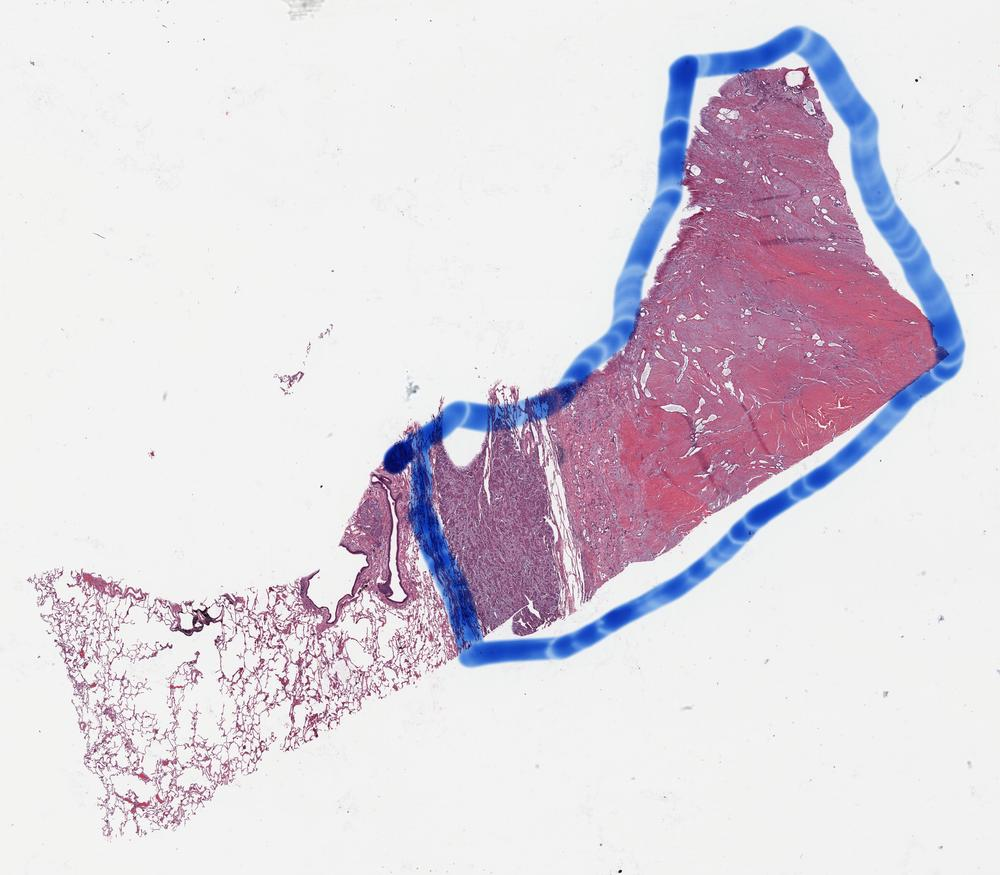

In [1]:
from IPython.display import Image
data_dir = "/data/Training-MG/files/data/AI_praticals_2025/AI_pratical_1_trident"
slide_name = "TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4"
Image(filename=f"{data_dir}/hest/thumbnails/{slide_name}.jpg")

⚠️ Because this pratical is only two hours long and some things are very long to compute on CPU, we replace them with placeholder methods below.
If you want to test the true methods after the pratical on a GPU, just comment the lines of code below and run your code as before.

In [2]:
import sys
sys.path.append(f"{data_dir}/utils")
from monkey_patch import segment_tissue, extract_patch_features, extract_slide_features
from trident.wsi_objects.OpenSlideWSI import OpenSlideWSI

OpenSlideWSI.segment_tissue = segment_tissue
OpenSlideWSI.extract_patch_features = extract_patch_features
OpenSlideWSI.extract_slide_features = extract_slide_features

/data/Training-MG/files/data/AI_praticals_2025/MG_AI/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


## 1. Segmentation
This step will separate the tissue from the background.
Note that if you use the Trident repo on your own later on, you can also do this step with a batch of WSIs with the following command line:
`python run_batch_of_slides.py --task seg --wsi_dir your/wsi/dir --job_dir your/output/dir --segmenter hest`
This will run the segmentation on the batch of WSIs using Hest segmenter (`--segmenter hest`). The flag `--remove-artifacts` can optionnally be added to remove artifacts.

First, let's load the slide

In [3]:
from trident import load_wsi
slide = load_wsi(slide_path=f"{data_dir}/slide/{slide_name}.svs", lazy_init=False)

Now, let's load the segmentation model

In [4]:
from trident.segmentation_models import segmentation_model_factory
segmentation_model = segmentation_model_factory(model_name="hest")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

If you want to see what HEST looks like

In [5]:
segmentation_model

HESTSegmenter(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

We can now segment the slide with the loaded model, at magnification 20x, and store them in a `trident_processed` folder.

In [6]:
job_dir = "./trident_processed"
slide.segment_tissue(
    segmentation_model=segmentation_model,
    target_mag=20,
    job_dir=job_dir,
    holes_are_tissue=True,
    device='cpu',
    num_workers=8,
    verbose=True
    )

This would run model HESTSegmenter on cpu, not removing tiles containing holes, using a magnification of 20x, a batch_size of 16, 8 workers, and save the results to ./trident_processed


Let's have a look at the segmentation

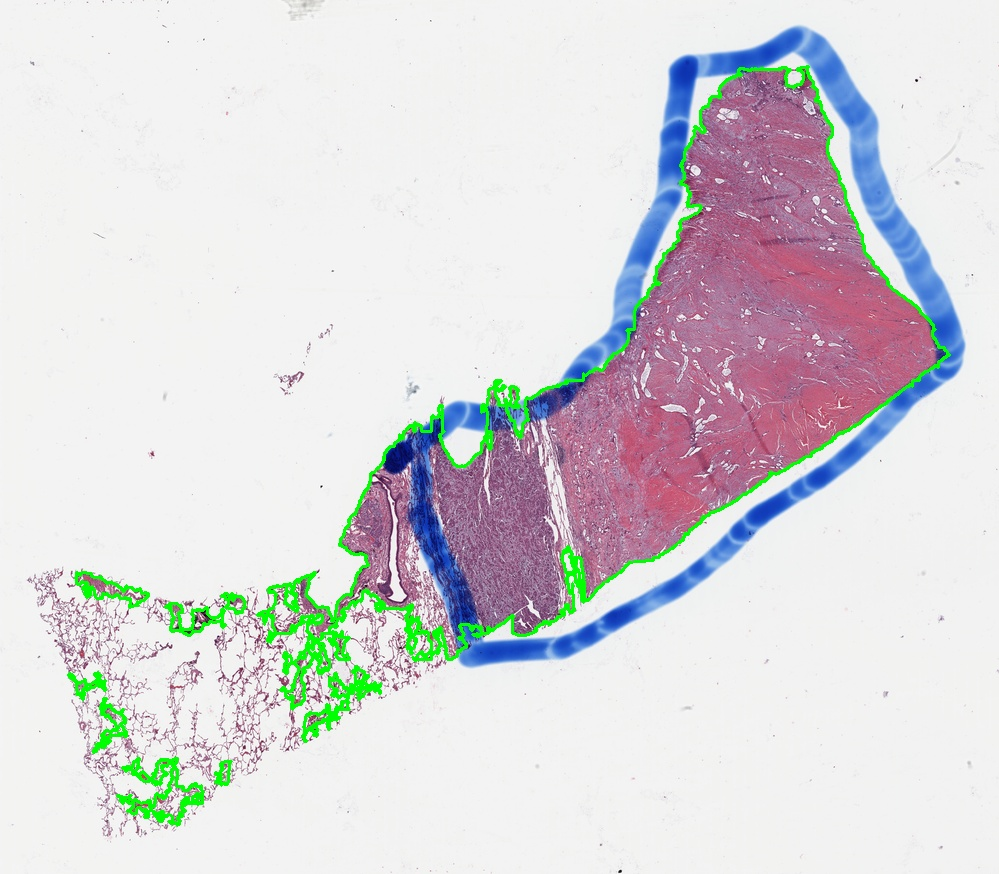

In [7]:
Image(filename=f"{job_dir}/contours/{slide_name}.jpg")

What do you think of the quality of the segmentation? How can it be improved?

By default, the segmenter consider holes as tissue. What happens if we set it to False?

In [8]:
import copy
job_dir_no_holes = "./trident_processed_no_holes"
slide_no_holes = copy.copy(slide)
slide_no_holes.segment_tissue(segmentation_model=segmentation_model,
    target_mag=20,
    job_dir=job_dir_no_holes,
    holes_are_tissue=False,
    device='cpu',
    num_workers=8,
    verbose=True)  # Complete this code to rerun the segmentation and remove tiles containing holes

This would run model HESTSegmenter on cpu, removing tiles containing holes, using a magnification of 20x, a batch_size of 16, 8 workers, and save the results to ./trident_processed_no_holes


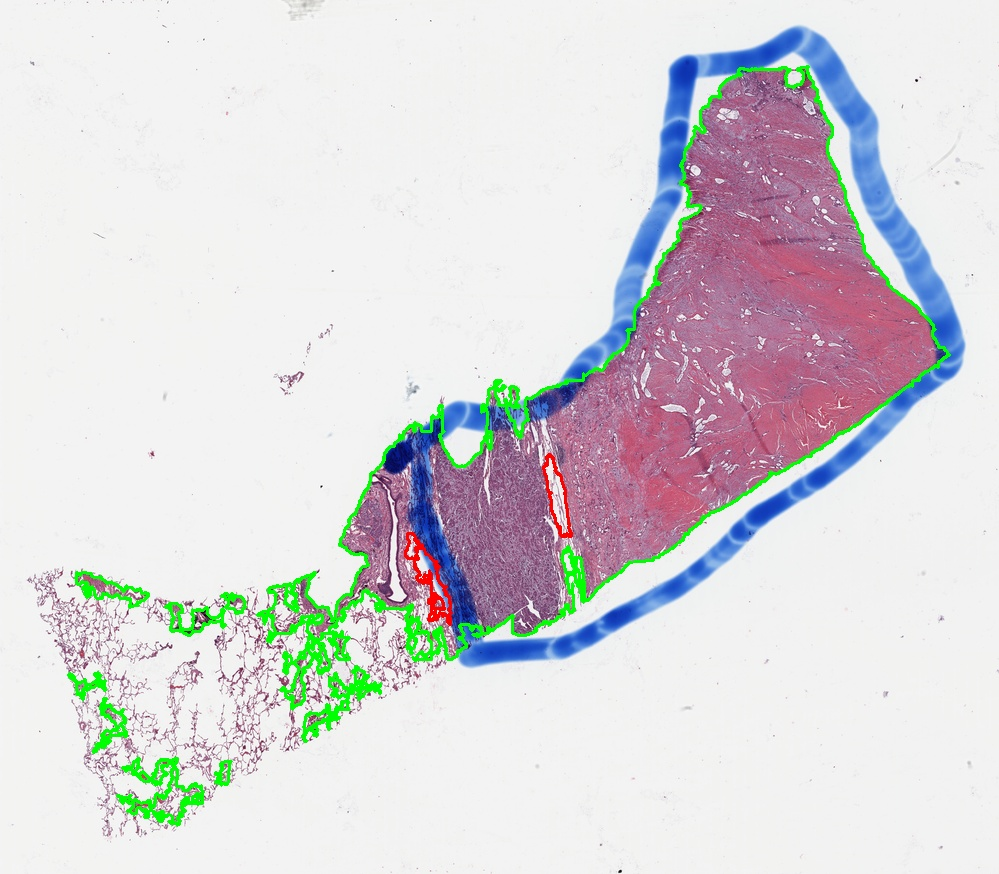

In [9]:
Image(filename=f"{job_dir_no_holes}/contours/{slide_name}.jpg")

We can try to use an additional artifact remover to get rid of the tiles with penmarks.
This model is named `grandqc_artifact`. It can be loaded in the same way as the segmentation model

In [10]:
artifact_remover_model = segmentation_model_factory(model_name="grandqc_artifact", remove_penmarks_only=True) # Complete this code to load grandqc_artifact

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

If you want to see what grandQC_artifact looks like

In [11]:
artifact_remover_model

GrandQCArtifactSegmenter(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
  

We now need to do a second pass of segment_tissue using the `artifact_remover_model`

In [12]:
job_dir_no_pen = "./trident_processed_no_pen"
slide_no_pen = copy.copy(slide)
slide_no_pen.segment_tissue(segmentation_model=artifact_remover_model,
    target_mag=20,
    job_dir=job_dir_no_pen,
    holes_are_tissue=False,
    device='cpu',
    num_workers=8,
    verbose=True) # Complete this code to rerun the segmentation and remove tiles containing penmarks

This would run model GrandQCArtifactSegmenter on cpu, removing tiles containing holes, using a magnification of 20x, a batch_size of 16, 8 workers, and save the results to ./trident_processed_no_pen


Let's have a look at the artifact removal. Is this better than the initial result?

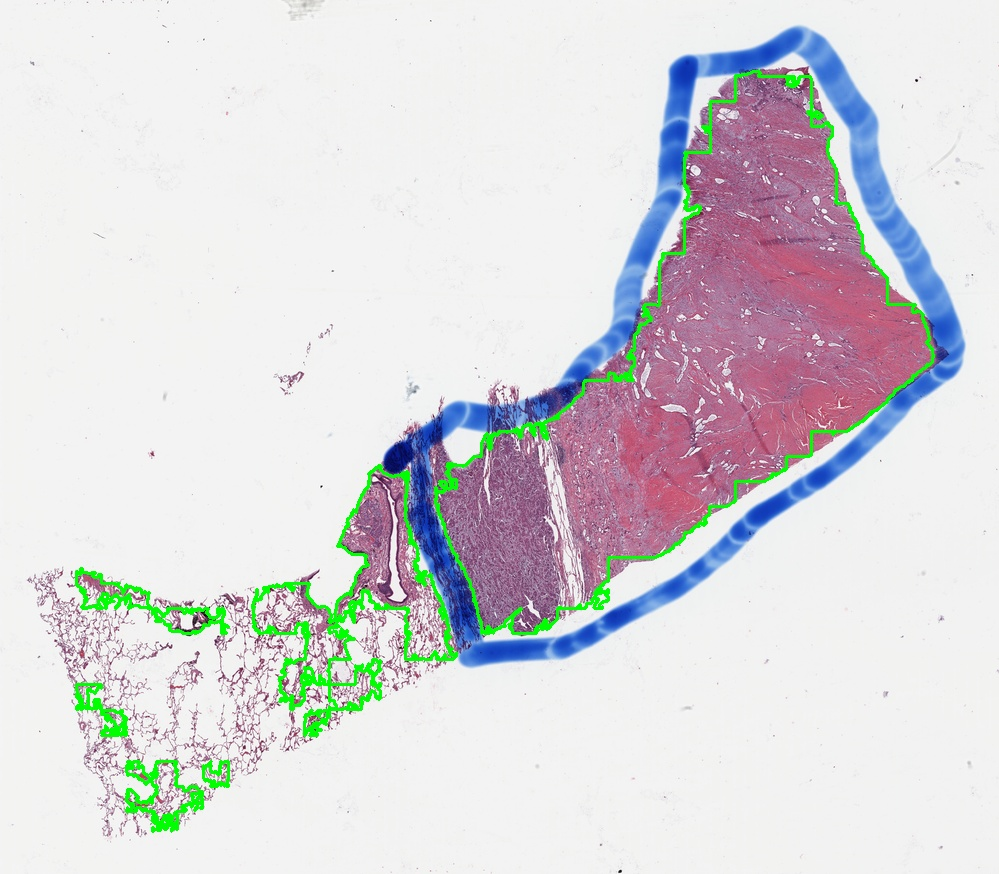

In [13]:
Image(filename=f"{job_dir_no_pen}/contours/{slide_name}.jpg")

## 2. Tiling
This step will split the WSI into smaller tiles.
Note that if you use the Trident repo on your own later on, you can also do this step with a batch of WSIs with the following command line:
`python run_batch_of_slides.py --task coords --wsi_dir your/wsi/dir --job_dir your/output/dir --mag 20 --patch_size 512 --overlap 0`
This will create tiles of size 512 x 512 px at 20x magnification, with 0px overlap.

In [14]:
job_dir = "./trident_processed"
overlap = 0
coords_dir = f"{job_dir}/20x_512px_{overlap}px_overlap"
# We perform the tiling
coords_path = slide.extract_tissue_coords(
    target_mag=20,
    patch_size=512,
    save_coords=coords_dir,
    overlap=overlap
)
# And visualise it
viz_coords_path = slide.visualize_coords(
    coords_path=coords_path,
    save_patch_viz=f"{coords_dir}/coords_visualization",
)
print(f"Tissue coordinates extracted and saved to {viz_coords_path}.")

Tissue coordinates extracted and saved to ./trident_processed/20x_512px_0px_overlap/coords_visualization/TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.jpg.


Now, let's look at the tiling results. Did we get a lot of tiles using a shape of 512 x 512 px ? Does this take the previous segmentation into account?

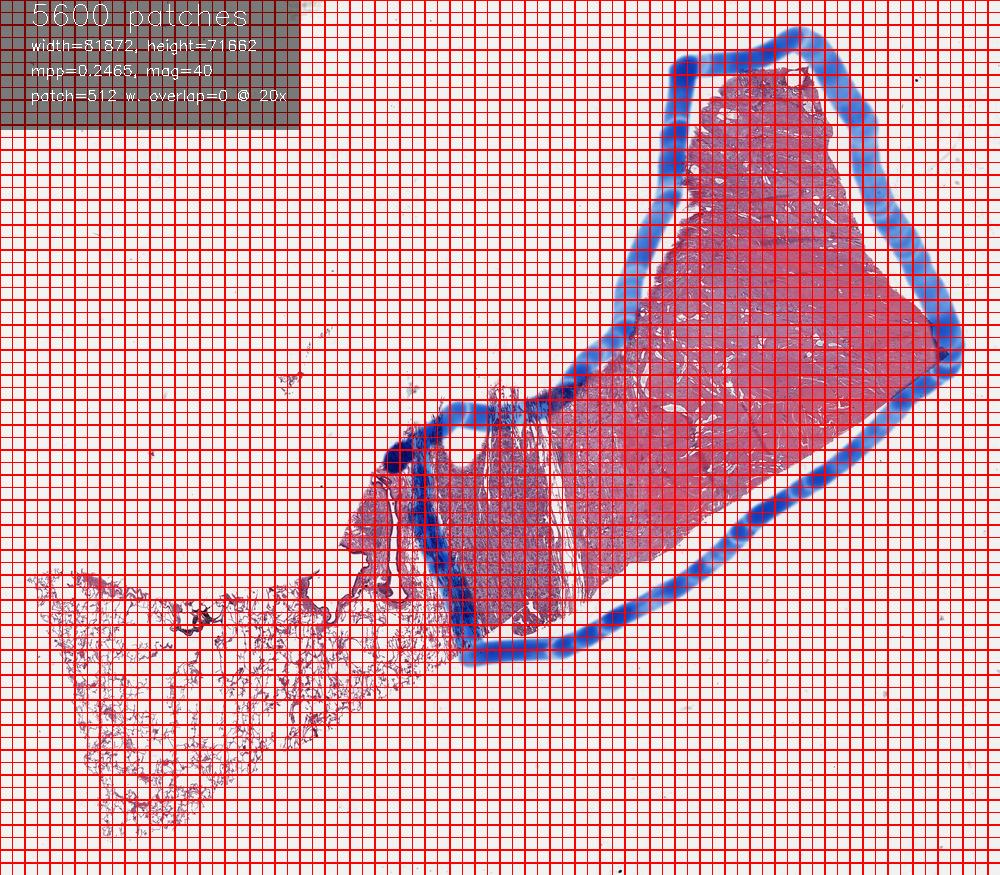

In [15]:
Image(viz_coords_path)

In [16]:
import h5py
from lovely_numpy import lo

with h5py.File(f"./trident_processed/20x_512px_0px_overlap/patches/{slide_name}_patches.h5") as f: # Add the h5 filename you found above
    coords = f["coords"][:] # Extract the coordinates of the patches embeddings as a numpy array
print(lo(coords)) # Pretty display of the np array

array[5600, 2] i64 n=11200 (88Kb) x∈[0, 80896] μ=3.789e+04 σ=2.236e+04


Let's try this with some overlap.

In [17]:
overlap = 200 # Change to the overlap value of your choice. It must be an positive integer lower than 512.
coords_dir_overlap = f"{job_dir}/20x_512px_{overlap}px_overlap"
# We perform the tiling
coords_path = slide.extract_tissue_coords(
    target_mag=20,
    patch_size=512,
    save_coords=coords_dir_overlap,
    overlap=overlap
)
# And visualise it
viz_coords_path = slide.visualize_coords(
    coords_path=coords_path,
    save_patch_viz=f"{coords_dir_overlap}/coords_visualization",
)
print(f"Tissue coordinates extracted and saved to {viz_coords_path}.")

Tissue coordinates extracted and saved to ./trident_processed/20x_512px_200px_overlap/coords_visualization/TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.jpg.


What changes in the tiling?

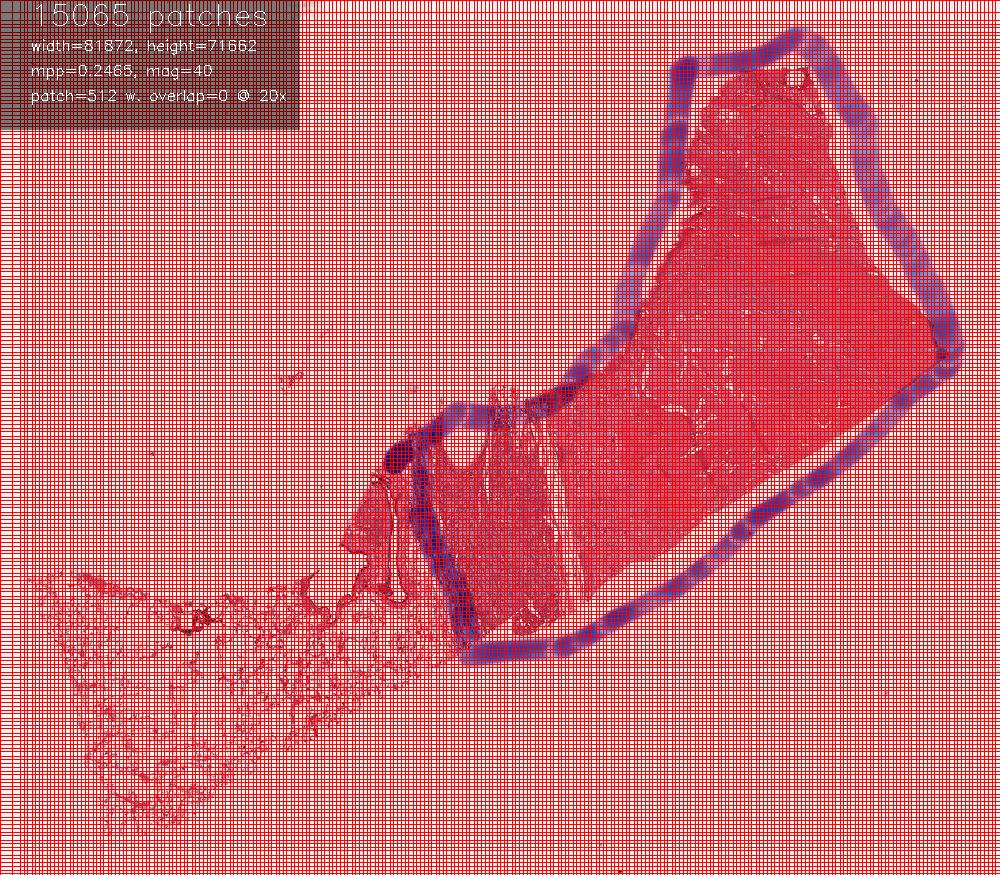

In [18]:
Image(viz_coords_path)

Now, complete both code cells below to compute the tiling for the segmentation version without holes and without penmarks.
We will use them in the next section.

In [19]:
overlap = 0
coords_dir_no_holes = f"{job_dir_no_holes}/20x_512px_{overlap}px_overlap"
# Complete the code below to perform the tiling
coords_path_no_holes = slide_no_holes.extract_tissue_coords(
    target_mag=20,
    patch_size=512,
    save_coords=coords_dir_no_holes,
    overlap=overlap
)
# Complete the code below to visualise it
viz_coords_path_no_holes = slide_no_holes.visualize_coords(
    coords_path=coords_path_no_holes,
    save_patch_viz=f"{coords_dir_no_holes}/coords_visualization",
)
print(f"Tissue coordinates extracted and saved to {viz_coords_path_no_holes}.")

Tissue coordinates extracted and saved to ./trident_processed_no_holes/20x_512px_0px_overlap/coords_visualization/TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.jpg.


In [20]:
overlap = 0
coords_dir_no_pen = f"{job_dir_no_pen}/20x_512px_{overlap}px_overlap"
# Complete the code below to perform the tiling
coords_path_no_pen = slide_no_pen.extract_tissue_coords(
    target_mag=20,
    patch_size=512,
    save_coords=coords_dir_no_pen,
    overlap=overlap
)
# Complete the code below to visualise it
viz_coords_path_no_pen = slide_no_pen.visualize_coords(
    coords_path=coords_path_no_pen,
    save_patch_viz=f"{coords_dir_no_pen}/coords_visualization",
)
print(f"Tissue coordinates extracted and saved to {viz_coords_path_no_pen}.")

Tissue coordinates extracted and saved to ./trident_processed_no_pen/20x_512px_0px_overlap/coords_visualization/TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.jpg.


## 3. Tile embedding
This step will transform the tiles into vector representations: the tile embeddings.
Note that if you use the Trident repo on your own later on, you can also do this step with a batch of WSIs with the following command line:
`python run_batch_of_slides.py --task feat --wsi_dir your/wsi/dir --job_dir your/output/dir --mag 20 --patch_size 512 --patch_encoder conch_v15`
This will create tile embeddings using the foundation model CONCH v 1.5.

In [21]:
from trident.patch_encoder_models import encoder_factory
from trident.patch_encoder_models import encoder_registry as patch_encoder_registry
# We load CONCH v1.5
encoder = encoder_factory("conch_v15")
# We set it to evaluation mode, as we do not intend to fine tune it.
encoder.eval()

Conchv15InferenceEncoder(
  (model): CONCHVisionTower(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1)

In [22]:
# The results will be saved into ./trident_processed/20x_512px_0px_overlap/features_conch_v15
tiles_path = f"{coords_dir}/features_conch_v15"
coords_path = f"{coords_dir}/patches/{slide.name}_patches.h5"
slide.extract_patch_features(
        patch_encoder=encoder,
        coords_path=coords_path,
        save_features=tiles_path,
        batch_limit=16
    )

This would run model Conchv15InferenceEncoder on cuda:0, using the coordinates stored in ./trident_processed/20x_512px_0px_overlap/patches/TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4_patches.h5, a maximum batch size of 16, and save the results to ./trident_processed/20x_512px_0px_overlap/features_conch_v15 as h5 files


Now, let's look at the content of the folder. What is there?

In [23]:
!ls ./trident_processed/20x_512px_0px_overlap/

coords_visualization  patches		      visualization
features_conch_v15    slide_features_feather


Let's look inside the visualization folder listed above

In [24]:
!ls ./trident_processed/20x_512px_0px_overlap/visualization

TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.jpg


Let's look inside the jpg file listed above

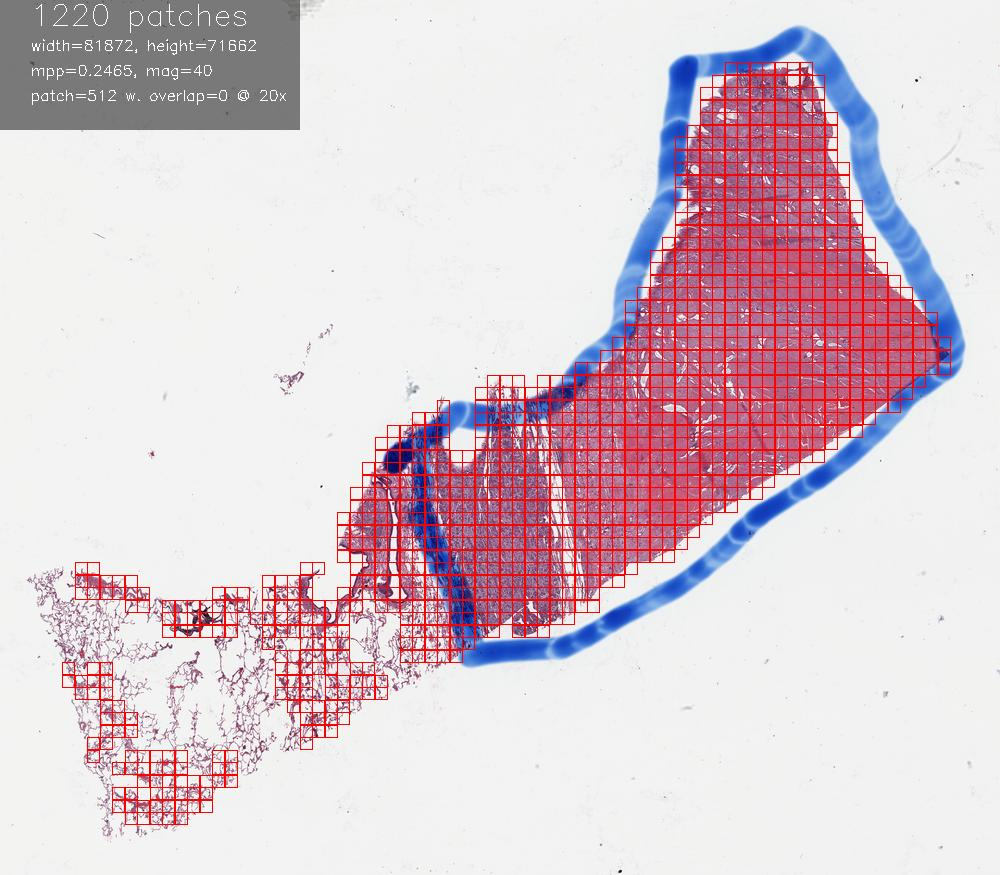

In [25]:
Image(filename=f"./trident_processed/20x_512px_0px_overlap/visualization/{slide_name}.jpg")

How many tiles were encoded for this slide? Does this match the number of tiles from the segmentation step? Why?

Let's repeat the process using the segmentation where we removed tiles with holes

In [26]:
# The results will be saved into ./trident_processed_no_holes/20x_512px_0px_overlap/features_conch_v15
tiles_path_no_holes = f"{coords_dir_no_holes}/features_conch_v15"
coords_path_no_holes = f"{coords_dir_no_holes}/patches/{slide.name}_patches.h5"
# Fill in the code below to extract patch features using a segmentation where holes are removed
slide_no_holes.extract_patch_features(patch_encoder=encoder,
        coords_path=coords_path_no_holes,
        save_features=tiles_path_no_holes,
        batch_limit=16)

This would run model Conchv15InferenceEncoder on cuda:0, using the coordinates stored in ./trident_processed_no_holes/20x_512px_0px_overlap/patches/TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4_patches.h5, a maximum batch size of 16, and save the results to ./trident_processed_no_holes/20x_512px_0px_overlap/features_conch_v15 as h5 files


Now, let's look at the content of the folder. What is there?

In [27]:
!ls ./trident_processed_no_holes/20x_512px_0px_overlap/

coords_visualization  patches		      visualization
features_conch_v15    slide_features_feather


Let's look inside the visualization folder listed above

In [28]:
!ls ./trident_processed_no_holes/20x_512px_0px_overlap/visualization

TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.jpg


Let's look inside the jpg file listed above

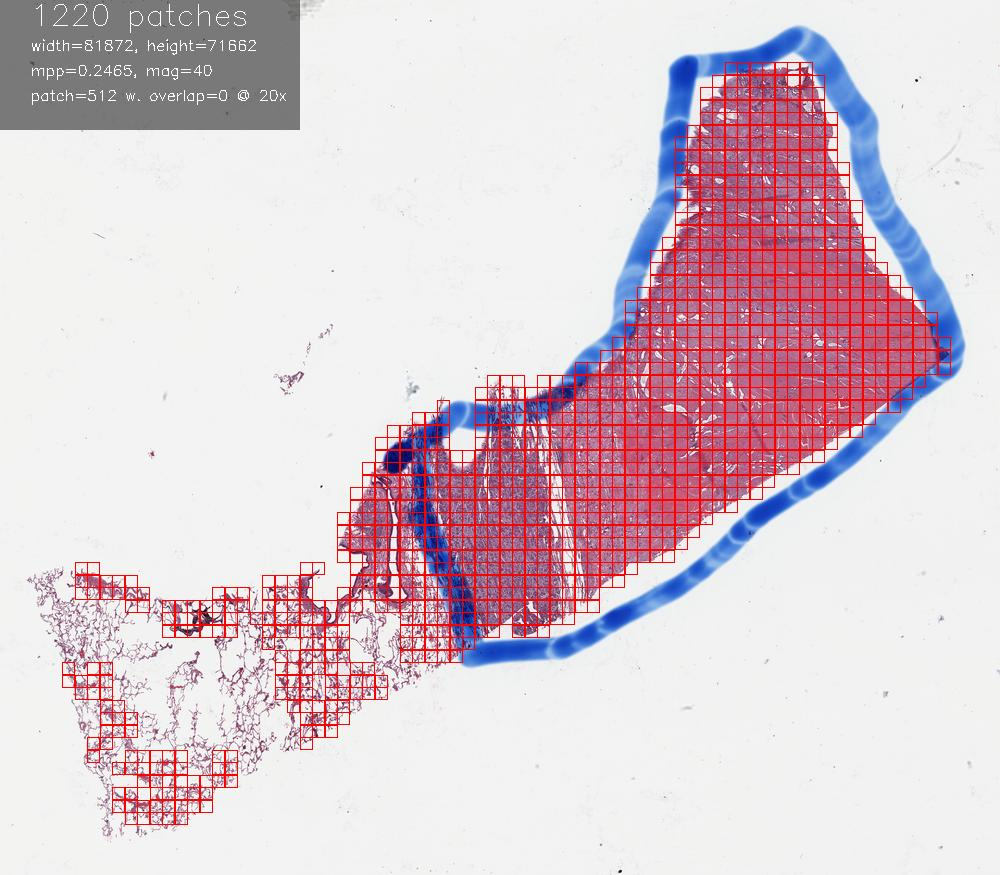

In [29]:
Image(filename=f"./trident_processed_no_holes/20x_512px_0px_overlap/visualization/{slide_name}.jpg")

How many tiles were encoded for this slide? How many where removed compared to the classical segmentation? why?

Let's repeat the process using the segmentation where we removed tiles with penmarks

In [30]:
# Fill in the code below to extract patch features using a segmentation where holes are removed
# The results will be saved into ./trident_processed_no_pen/20x_512px_0px_overlap/features_conch_v15
tiles_path_no_pen = f"{coords_dir_no_pen}/features_conch_v15"
coords_path_no_pen = f"{coords_dir_no_pen}/patches/{slide.name}_patches.h5"
slide_no_pen.extract_patch_features(patch_encoder=encoder,
        coords_path=coords_path_no_pen,
        save_features=tiles_path_no_pen,
        batch_limit=16)

This would run model Conchv15InferenceEncoder on cuda:0, using the coordinates stored in ./trident_processed_no_pen/20x_512px_0px_overlap/patches/TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4_patches.h5, a maximum batch size of 16, and save the results to ./trident_processed_no_pen/20x_512px_0px_overlap/features_conch_v15 as h5 files


Fill in the code to retrieve the jpg file on the trident_processed_no_pen folder

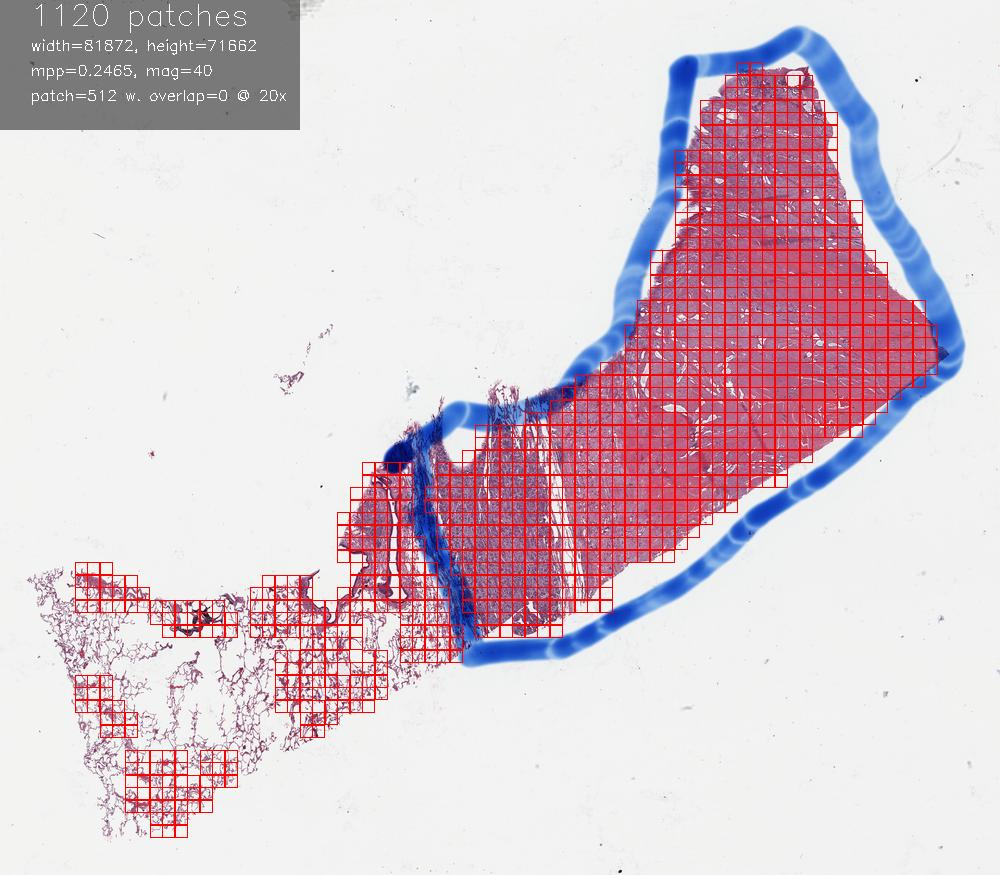

In [31]:
Image(filename=f"./trident_processed_no_pen/20x_512px_0px_overlap/visualization/{slide_name}.jpg")

How many tiles were encoded for this slide? How many where removed compared to the classical segmentation? Are the tiles at the same coordinates?

## 4. Slide embedding
This step will transform the tiles into vector representations: the tile embeddings.
Note that if you use the Trident repo on your own later on, you can also do this step with a batch of WSIs with the following command line:
`python run_batch_of_slides.py --task feat --wsi_dir your/wsi/dir --job_dir your/output/dir --mag 20 --patch_size 512 --slide_encoder titan`
This will create slide embeddings using the foundation model Titan.

In [32]:
from trident.slide_encoder_models.load import encoder_factory
slides_path = f"{coords_dir}/slide_features_feather"
slide_encoder = encoder_factory("feather")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at /home/bonhemel/.cache/huggingface/hub/models--MahmoodLab--abmil.base.conch_v15.pc108-24k/snapshots/423c894c738294e8b0ac38938108180a2c21dd43 were not used when initializing ABMILModel: ['model.classifier.bias', 'model.classifier.weight']
- This IS expected if you are initializing ABMILModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ABMILModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
slide.extract_slide_features(
    patch_features_path=tiles_path,
    slide_encoder=slide_encoder,
    save_features=slides_path,
)

This would run model FeatherSlideEncoder on cuda:0, using the patches stored in ./trident_processed/20x_512px_0px_overlap/features_conch_v15, and save the results to ./trident_processed/20x_512px_0px_overlap/slide_features_feather


Now, let's look at the content of the folder `slides_path`. What is there?

In [34]:
!ls ./trident_processed/20x_512px_0px_overlap/slide_features_feather

TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.h5


Let's look inside the h5 file listed above

In [35]:
import h5py
from lovely_numpy import lo

with h5py.File(f"{slides_path}/{slide_name}.h5") as f: # Add the h5 filename you found above
    feats = f["features"][:] # Extract the slide embedding as a numpy array
    print(lo(feats))

array[512] f32 2Kb x∈[0., 6.808] μ=0.214 σ=0.657


What is the dimensionality of the obtained representation?

Now let's extract the slide features for tile embeddings without holes.

In [36]:
# Here put the code to compute the slide embeddings using the segmentation where holes are removed
slides_path_no_holes = f"{coords_dir_no_holes}/slide_features_feather"
slide_no_holes.extract_slide_features(patch_features_path=tiles_path_no_holes,
    slide_encoder=slide_encoder,
    save_features=slides_path_no_holes,)
!ls ./trident_processed_no_holes/20x_512px_0px_overlap/slide_features_feather
with h5py.File(f"{slides_path_no_holes}/{slide_name}.h5") as f: # Add the h5 filename you found above
    feats_no_holes = f["features"][:] # Extract the slide embedding as a numpy array
print(lo(feats_no_holes))

This would run model FeatherSlideEncoder on cuda:0, using the patches stored in ./trident_processed_no_holes/20x_512px_0px_overlap/features_conch_v15, and save the results to ./trident_processed_no_holes/20x_512px_0px_overlap/slide_features_feather
TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.h5
array[512] f32 2Kb x∈[0., 6.808] μ=0.214 σ=0.657


Now let's extract the slide features for tile embeddings without penmarks.

In [37]:
# Here put the code to compute the slide embeddings using the segmentation where penmarks are removed
slides_path_no_pen = f"{coords_dir_no_pen}/slide_features_feather"
slide_no_pen.extract_slide_features(patch_features_path=tiles_path_no_pen,
    slide_encoder=slide_encoder,
    save_features=slides_path_no_pen,)
!ls ./trident_processed_no_pen/20x_512px_0px_overlap/slide_features_feather
with h5py.File(f"{slides_path_no_pen}/{slide_name}.h5") as f: # Add the h5 filename you found above
    feats_no_pen = f["features"][:] # Extract the slide embedding as a numpy array
print(lo(feats_no_pen))

This would run model FeatherSlideEncoder on cuda:0, using the patches stored in ./trident_processed_no_pen/20x_512px_0px_overlap/features_conch_v15, and save the results to ./trident_processed_no_pen/20x_512px_0px_overlap/slide_features_feather
TCGA-MQ-A6BQ-01Z-00-DX1.72BF21E4-17D6-436B-AAD9-7960342894F4.h5
array[512] f32 2Kb x∈[0., 6.912] μ=0.217 σ=0.668


Now let's compare these representations.

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
cosine_similarity(np.array([feats, feats_no_holes, feats_no_pen]))

array([[0.99999976, 0.99999976, 0.99996924],
       [0.99999976, 0.99999976, 0.99996924],
       [0.99996924, 0.99996924, 1.0000001 ]], dtype=float32)

How high is the similarity between the different slide embeddings? Did the different segmentation methods impact the slide representation?